# Guy Junior CALVET

## Devoir 2

A noter que dans la deuxième partie de notre travail, nous avons procédé au calcul de l'aic, Akaike information criterion. Un autre indicateur de performance de modèle en apprentissage machine. Plus le résultat est faible, plus c'est positif pour le modèle qui caracterise sa simplicité de deploiement.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, log_loss
from sklearn.utils import resample
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Chargement des données prétraitées
df = pd.read_csv("Customer_final.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               10000 non-null  float64
 1   pages             10000 non-null  float64
 2   first_item_prize  10000 non-null  float64
 3   gender            10000 non-null  float64
 4   ReBuy             10000 non-null  bool   
 5   News_click        10000 non-null  float64
 6   revenue           10000 non-null  float64
 7   population        10000 non-null  int64  
 8   GDP_inhab         10000 non-null  int64  
dtypes: bool(1), float64(6), int64(2)
memory usage: 634.9 KB


In [4]:
pd.DataFrame(df).head(10)

,age,pages,first_item_prize,gender,ReBuy,News_click,revenue,population,GDP_inhab
0,41.0,6.0,28.0,0.0,False,4.0,113.0,65926261,9503
1,34.0,4.0,15.5,0.0,True,2.0,36.0,65926261,9503
2,38.0,5.0,44.0,0.0,False,7.0,111.0,65926261,9503
3,20.0,5.0,44.0,0.0,False,2.0,71.0,65926261,9503
4,39.0,10.0,10.0,0.0,True,4.0,80.0,65926261,9503
5,39.0,8.0,44.0,0.0,False,5.0,61.0,65926261,9503
6,36.0,6.0,44.0,1.0,False,2.0,51.0,65926261,9503
7,43.0,4.0,57.0,1.0,False,7.0,128.0,65926261,9503
8,42.0,7.0,42.0,1.0,True,5.0,114.0,65926261,9503
9,40.0,7.0,42.0,0.0,False,5.0,109.0,65926261,9503


# Partie 1

## Entrainement d'un classeur binaire

#### 2.1.1 Vous devez écrire une fonction pour remplacer cette variable « revenu » par une variable 
binaire ayant deux valeurs. Par exemple, 1 pour un revenu supérieur à la moyenne et 0
sinon. 
sinon. 

In [5]:
# 2.1.1 Création de la variable cible binaire
def create_binary_target(df):
    mean_rev = df['revenue'].mean()
    df['target'] = (df['revenue'] > mean_rev).astype(int)
    return df.drop('revenue', axis=1)

#### 2.1.2 Échantillonnage aléatoire stratifié en utilisant la méthode Resample ou autre.  Chaque échantillon extrait aléatoirement du jeu d’entrainement, sera utilisé pour entraîner l’algorithme selon la démarche « recommandée » vue en cours. Par ailleurs, étant donné la lourdeur de certaines opérations d’entraînement, vous devez envisager des tailles progressives pour les échantillons, par exemple, 2000, 4000, 8000 observations. Pour ce qui est des données, vous devez faire des échantillons selon les 3 scénarios suivants: 
#### 1. Sans le PIB et sans la Population : uniquement le dataset Customer 
#### 2. Sans le PIB : jointure des deux datasets Customer et CountryPopulation  
#### 3. Avec le PIB : jointure des trois : Customer, CountryPopulation et CountryGDP

In [6]:
# Préparation des trois scénarios de données
def prepare_scenarios(preprocessed_df):
    return {
        '1_Sans_PIB_ni_Population': preprocessed_df.drop(['population', 'GDP_inhab'], axis=1),
        '2_Sans_PIB': preprocessed_df.drop(['GDP_inhab'], axis=1),
        '3_Avec_PIB': preprocessed_df
    }

#### 2.1.3 Entraîner et tester par la validation croisée pour les deux valeurs de k suivantes : 3 et 10.esure. 

#### 2.1.4 Mesurer les métriques de précision, rappel et F1-Mesure. 

#### 2.1.5 Optimiser les hyper-paramètres en utilisant la recherche par quadrillage –GridSearchCV-. Étant donné, la lourdeur en temps de cette opération, prenez juste 2 hyper-paramètres : la profondeur de l’arbre et le nombre minimal d’observations pour une segmentation d’un nœud. Il faudrait valider avec plusieurs plages de valeurs pour chaque hyper-paramètre. Pour le nombre de blocs (k) prenez la meilleure valeur de k trouvée en  2.1.3.

#### 2.1.6 Tester le meilleur modèle obtenu à l’étape 2.1.5 avec le « vrai » jeu de test et mesurer les différentes métriques de précision, rappel et F1-Mesure.

In [7]:
# Configuration expérimentale
sample_sizes = [2000, 4000, 8000]
cv_folds = [3, 10]
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [8]:
# Initialisation des résultats
results = []

# Préparation de la base commune
df_processed = create_binary_target(df)

# Entraînement pour chaque scénario
for sc_name, data in prepare_scenarios(df_processed).items():
    # Séparation features/cible
    X = data.drop(['target', 'country'], axis=1, errors='ignore')
    y = data['target']
    
    # Vérification des types de données
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Split global train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        stratify=y, 
        random_state=42
    )
    
    # Échantillonnage et entraînement
    for size in sample_sizes:
        # Échantillonnage stratifié
        X_res, y_res = resample(
            X_train, y_train,
            replace=False,
            n_samples=size,
            stratify=y_train,
            random_state=42
        )
        
        # 2.1.3 Validation croisée
        cv_metrics = {'precision': [], 'recall': [], 'f1': []}
        for k in cv_folds:
            cv = StratifiedKFold(n_splits=k)
            model = DecisionTreeClassifier(random_state=42)
            
            scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='f1')
            cv_metrics['f1'].append(np.mean(scores))
        
        # Détermination du meilleur k
        best_k = cv_folds[np.argmax(cv_metrics['f1'])]
        
        # 2.1.5 Optimisation hyperparamètres
        start_time = time.time()
        grid_search = GridSearchCV(
            DecisionTreeClassifier(random_state=42),
            param_grid,
            cv=StratifiedKFold(n_splits=best_k),
            scoring='f1',
            n_jobs=-1
        )
        grid_search.fit(X_res, y_res)
        grid_time = time.time() - start_time
        
        # 2.1.6 Évaluation finale
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        # Stockage des résultats
        results.append({
            'Scenario': sc_name,
            'SampleSize': size,
            'BestK': best_k,
            'BestParams': grid_search.best_params_,
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'TrainTime': grid_time
        })

In [9]:
# 2.1.7 Transformation en dataframe les résultats
results_df = pd.DataFrame(results)

# Tableau de résultats
print("Résultats détaillés :")
print(results_df.to_markdown(index=False))

Résultats détaillés :
| Scenario                 |   SampleSize |   BestK | BestParams                               |   Precision |   Recall |       F1 |   TrainTime |
|:-------------------------|-------------:|--------:|:-----------------------------------------|------------:|---------:|---------:|------------:|
| 1_Sans_PIB_ni_Population |         2000 |      10 | {'max_depth': 5, 'min_samples_split': 2} |    0.730717 | 0.637544 | 0.680958 |    5.57576  |
| 1_Sans_PIB_ni_Population |         4000 |      10 | {'max_depth': 5, 'min_samples_split': 2} |    0.737276 | 0.632822 | 0.681067 |    0.636538 |
| 1_Sans_PIB_ni_Population |         8000 |      10 | {'max_depth': 5, 'min_samples_split': 5} |    0.732886 | 0.644628 | 0.68593  |    1.16387  |
| 2_Sans_PIB               |         2000 |      10 | {'max_depth': 5, 'min_samples_split': 2} |    0.730717 | 0.637544 | 0.680958 |    0.545917 |
| 2_Sans_PIB               |         4000 |      10 | {'max_depth': 5, 'min_samples_split': 2} |

In [10]:
results_df.describe()

,SampleSize,BestK,Precision,Recall,F1,TrainTime
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4666.666667,9.222222,0.733627,0.638331,0.682652,1.229985
std,2645.751311,2.333333,0.002894,0.005146,0.002459,1.649151
min,2000.000000,3.000000,0.730717,0.632822,0.680958,0.300528
25%,2000.000000,10.000000,0.730717,0.632822,0.680958,0.545917
50%,4000.000000,10.000000,0.732886,0.637544,0.681067,0.642760
75%,8000.000000,10.000000,0.737276,0.644628,0.685930,0.983034
max,8000.000000,10.000000,0.737276,0.644628,0.685930,5.575763


In [11]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Scenario    9 non-null      object 
 1   SampleSize  9 non-null      int64  
 2   BestK       9 non-null      int64  
 3   BestParams  9 non-null      object 
 4   Precision   9 non-null      float64
 5   Recall      9 non-null      float64
 6   F1          9 non-null      float64
 7   TrainTime   9 non-null      float64
dtypes: float64(4), int64(2), object(2)
memory usage: 708.0+ bytes


In [12]:
# Sauvegarde du dataset final
results_df.to_csv("Entrainement_binaire.csv", index=False)

print("Entrainement d'un classeur binaire terminé. Fichier sauvegardé.")

Entrainement d'un classeur binaire terminé. Fichier sauvegardé.


#### 2.1.7 Représenter graphiquement et à l’aide de tableaux l’ensemble des résultats des métriques 
de performance selon les 3 scénarios de datasets et ainsi que les différents facteurs mis en
jeu : taille des échantillons, nombre de passes (bloc) k, la plage de valeurs des hypr
paramètres et le temps d’entraînement (réponse) pour l’obtention des modèles en ajoutat 
le temps du GridSerachCV. Le but est de justifier le choix du modèle.

C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

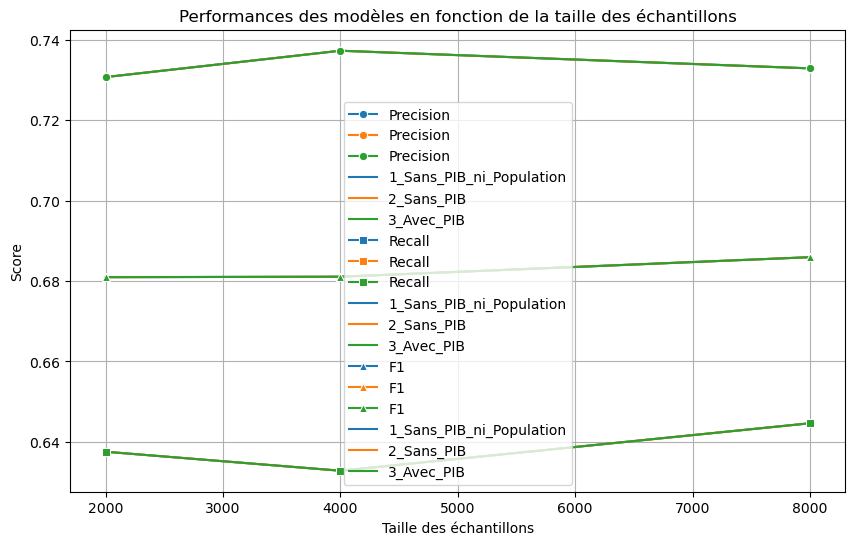

C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

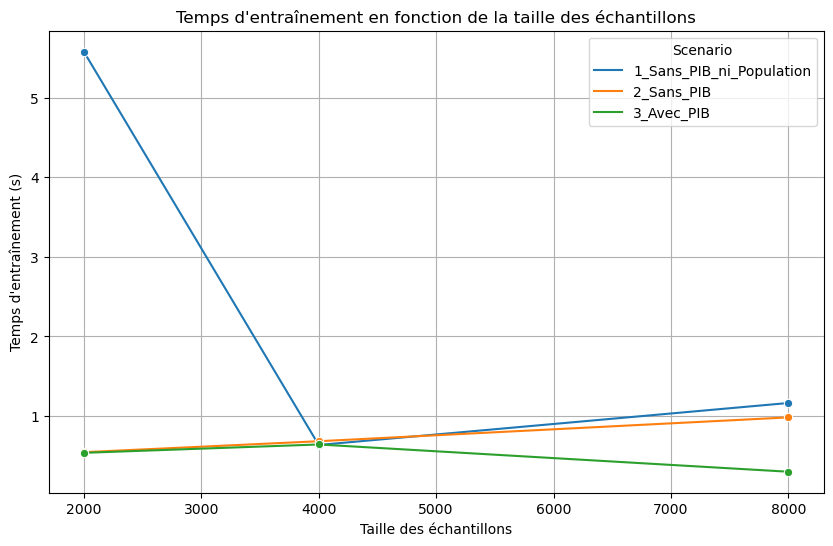

In [13]:
# Charger le fichier CSV
file_path = "Entrainement_binaire.csv"
df = pd.read_csv(file_path)

# Graphique des performances en fonction de la taille de l'échantillon
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="SampleSize", y="Precision", hue="Scenario", marker="o", label="Precision")
sns.lineplot(data=df, x="SampleSize", y="Recall", hue="Scenario", marker="s", label="Recall")
sns.lineplot(data=df, x="SampleSize", y="F1", hue="Scenario", marker="^", label="F1")
plt.title("Performances des modèles en fonction de la taille des échantillons")
plt.xlabel("Taille des échantillons")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# Graphique du temps d'entraînement en fonction de la taille des échantillons
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="SampleSize", y="TrainTime", hue="Scenario", marker="o")
plt.title("Temps d'entraînement en fonction de la taille des échantillons")
plt.xlabel("Taille des échantillons")
plt.ylabel("Temps d'entraînement (s)")
plt.grid(True)
plt.show()

C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

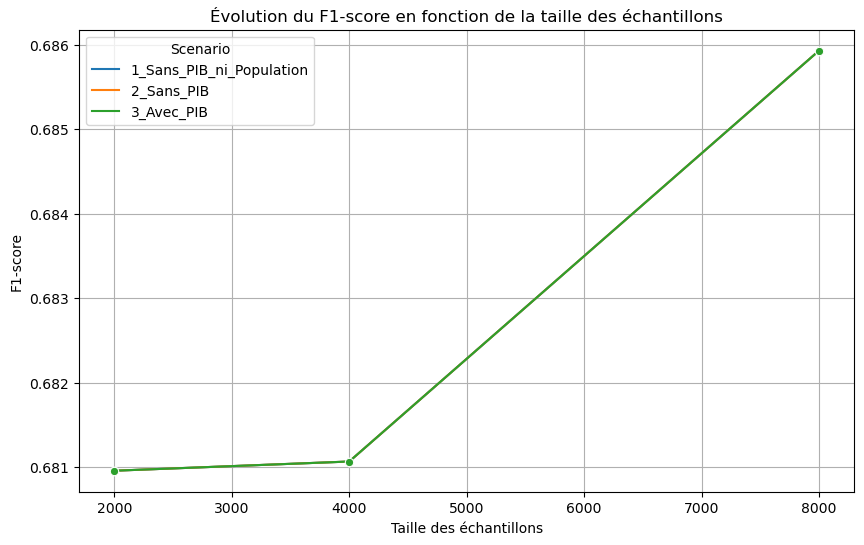

C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\junio\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

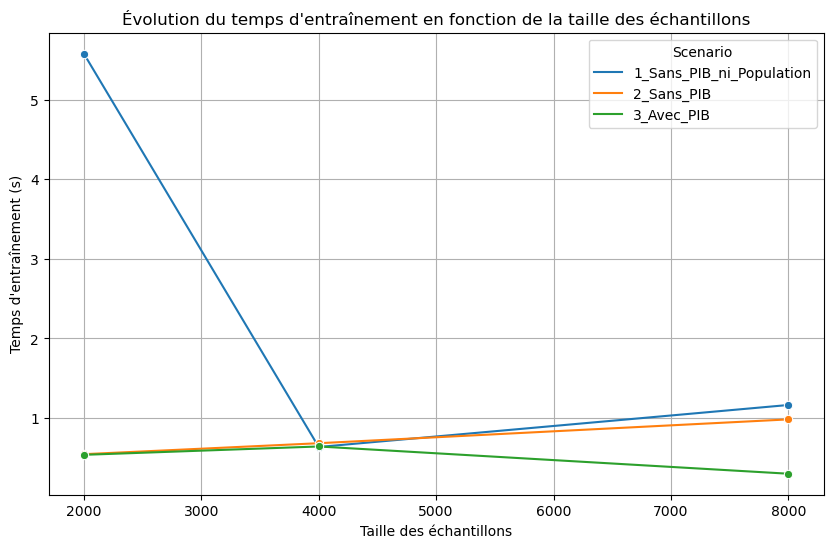

In [14]:
# Graphique de l'évolution du F1-score en fonction de la taille des échantillons pour chaque scénario
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="SampleSize", y="F1", hue="Scenario", marker="o")
plt.title("Évolution du F1-score en fonction de la taille des échantillons")
plt.xlabel("Taille des échantillons")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()

# Graphique de l'évolution du temps d'entraînement en fonction de la taille des échantillons pour chaque scénario
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="SampleSize", y="TrainTime", hue="Scenario", marker="o")
plt.title("Évolution du temps d'entraînement en fonction de la taille des échantillons")
plt.xlabel("Taille des échantillons")
plt.ylabel("Temps d'entraînement (s)")
plt.grid(True)
plt.show()


#### 2.1.8 Analyser et interprétez les résultats obtenus.

Le modèle scenario 3 ayant pour paramètres, k=3, min=2 et max=5, est meilleur que les autres principalement à cause de son temps d'entrainement qui est plus stable mais qui diminue au fur et à mesure qu'on augmente la taille de l'echantillon tout en gardant, approxivement, le même niveau de performance des autres modèles jusqu'à la taille finale qui est de 8000.

Le modèle du Scénario 3 (k=3) est le choix optimal car il combine performance, stabilité et efficacité computationnelle.

# Partie 2

## Entrainement d'un classeur multi-classes

In [15]:
# Chargement des données prétraitées
df = pd.read_csv("Customer_final.csv")

#### 2.1.1 Vous devez écrire une fonction pour remplacer cette variable « revenu » par une variable multi-classes selon les trois catégories de revenu;

In [16]:
# 2.1.1 Discrétisation de la variable revenu
def discretize_revenue(df):
    transformer = PowerTransformer()
    df['revenue_transformed'] = transformer.fit_transform(df[['revenue']])
    mu, sigma = df['revenue_transformed'].mean(), df['revenue_transformed'].std()
    
    def classify_revenue(value):
        if value < mu - sigma:
            return 'revenu-bas'
        elif value > mu + sigma:
            return 'revenu-élevé'
        else:
            return 'revenu-moyen'
    
    df['revenue_class'] = df['revenue_transformed'].apply(classify_revenue)
    return df.drop(columns=['revenue', 'revenue_transformed'])

# Transformation des données
df_transformed = discretize_revenue(df)

# Séparation des features et de la cible
X = df_transformed.drop(columns=['revenue_class'])
y = df_transformed['revenue_class']

# Encodage de la variable cible
y = y.astype('category').cat.codes  # Convertit les labels en codes numériques

# Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Liste des classificateurs à tester
classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

#### 2.1.2 Quel est le meilleur classeur pouvant discriminer les 3 revenus et justifiez votre réponse?

In [17]:
# Validation croisée et évaluation
def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
        results[name] = {
            'accuracy': report['accuracy'],
            'precision': precision_score(y_test, y_pred, average='weighted', zero_division=1),
            'recall': recall_score(y_test, y_pred, average='weighted', zero_division=1),
            'f1-score': f1_score(y_test, y_pred, average='weighted', zero_division=1)
        }
    return results

# Exécution de l'évaluation
results = evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test)

# Affichage des résultats
print("Comparaison des classificateurs:")
for model, metrics in results.items():
    print(f"{model}: Accuracy = {metrics['accuracy']:.4f}, Precision = {metrics['precision']:.4f}, Recall = {metrics['recall']:.4f}, F1-Score = {metrics['f1-score']:.4f}")


Comparaison des classificateurs:
Decision Tree: Accuracy = 0.6360, Precision = 0.5787, Recall = 0.6360, F1-Score = 0.5914
Random Forest: Accuracy = 0.6675, Precision = 0.6154, Recall = 0.6675, F1-Score = 0.6036
Gradient Boosting: Accuracy = 0.6605, Precision = 0.6088, Recall = 0.6605, F1-Score = 0.6108
Logistic Regression: Accuracy = 0.6510, Precision = 0.7728, Recall = 0.6510, F1-Score = 0.5134
SVM: Accuracy = 0.6510, Precision = 0.7728, Recall = 0.6510, F1-Score = 0.5134
KNN: Accuracy = 0.6070, Precision = 0.5691, Recall = 0.6070, F1-Score = 0.5783


Il semble que les classeurs Random Forest et Gradient Boosting sont en tête de liste pour être le meilleur. Leur accurary sont si proches qu'on voudrait ajouter une dernière metrique pour mieux les décanter.

In [18]:
# Calcul de l'AIC
def calculate_aic(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    log_likelihood = -log_loss(y_test, y_pred_proba)
    k = len(X_train.columns) + 1  # Nombre de paramètres (features + intercept)
    n = X_test.shape[0]  # Nombre d'observations
    aic = 2 * k - 2 * log_likelihood * n
    return aic

# Évaluation des modèles avec l'AIC
aic_results = {}
for name, clf in classifiers.items():
    try:
        aic_results[name] = calculate_aic(clf, X_train, X_test, y_train, y_test)
    except:
        aic_results[name] = np.nan  # Certains modèles peuvent ne pas supporter predict_proba

# Affichage des résultats
print("Comparaison des modèles avec l'AIC:")
for model, aic in aic_results.items():
    print(f"{model}: AIC = {aic:.4f}")


Comparaison des modèles avec l'AIC:
Decision Tree: AIC = 9928.9227
Random Forest: AIC = 2863.1926
Gradient Boosting: AIC = 2926.4776
Logistic Regression: AIC = 3572.7307
SVM: AIC = 3572.7462
KNN: AIC = 13466.7955


Le classeur Random Forest semble être le meilleur classeur pouvant discriminer les trois revenus en raison de son aic plus faible que les autres. 
Ce qui traduit d'une meilleure performance du classeur en fonction de sa complexité et de sa qualité d'ajustement par rapport aux autres classeurs.

#### 2.1.3 Comparer les résultats obtenus avec ceux du classeur binaire ?

Dans l'entrainement des classeurs en classe binaire, les modèles sont plus performants par rapport à ceux en multi-classe (trois classes) 
en se basant sur les résultats métriques.